In [3]:
datadir = 'workspace/competedata_train/'
libdir = 'workspace/'
outputdir = 'workspace/'
otherdir = 'workspace/'
train_bs_ = 16
valid_bs_ = 32
num_workers_ = 8

In [4]:
class CFG:
    seed=42
    device='GPU' #### ['TPU', 'GPU']
    nprocs=1 # [1, 8]
    num_workers=num_workers_
    train_bs=train_bs_
    valid_bs=valid_bs_
    fold_num=5

    target_cols=['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
           'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
           'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal', 'Swan Ganz Catheter Present']
    n_class=11
    accum_iter=1
    max_grad_norm=1000
    print_freq=100
    normalize_mean=[0.4824, 0.4824, 0.4824] # [0.485, 0.456, 0.406] [0.4824, 0.4824, 0.4824]
    normalize_std=[0.22, 0.22, 0.22] # [0.229, 0.224, 0.225] [0.22, 0.22, 0.22]
    
    suffix="1803" ####
    fold_list=[3] 
    epochs=18 ####
    model_arch="resnet200d" # efficientnet,resnet200d
    img_size=640
    optimizer="Adam"
    scheduler="CosineAnnealingLR"
    loss_fn="BCEWithLogitsLoss"
    scheduler_warmup=None # "GradualWarmupSchedulerV2"

    student= otherdir + 'resnet200d_0316_fold0_epoch6_stage2_cv9361.pth'

    warmup_epo=1
    warmup_factor = 10
    T_max= epochs-warmup_epo-2 if scheduler_warmup=="GradualWarmupSchedulerV2" else \
           epochs-warmup_epo-1 if scheduler_warmup=="GradualWarmupSchedulerV3" else epochs-1 # CosineAnnealingLR
    
    lr=1e-4
    min_lr=1e-6 
    weight_decay=0

    fix_mistake = True
    multihead = True
    gpu_parallel=False
    n_early_stopping=3
    debug=False ####

scheduler: CosineAnnealingLR
scheduler_warmup: None
lr: 0.0001
min_lr: 1e-06
weight_decay: 0


# Import

In [5]:
import sys; 

package_paths = [f'{libdir}pytorch-image-models-master']
for pth in package_paths:
    sys.path.append(pth)
    
import ast
from glob import glob
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
from tqdm import tqdm
from contextlib import contextmanager
import math

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler
import timm
import warnings
import joblib
from scipy.ndimage.interpolation import zoom
if CFG.device == 'TPU':
    !pip install -q pytorch-ignite
    import ignite.distributed as idist
elif CFG.device == 'GPU':
    from torch.cuda.amp import autocast, GradScaler

# helper

In [6]:
train_df = pd.read_csv(f'{datadir}train.csv')
submission_df = pd.read_csv(f'{datadir}sample_submission.csv')
train_annotations_df = pd.read_csv(f'{datadir}train_annotations.csv')

def fix_mistake_label(train_df, train_annotations_df, ann_index, uid, old_label, correct_label):
    train_df.loc[train_df.StudyInstanceUID==uid, old_label] = 0
    train_df.loc[train_df.StudyInstanceUID==uid, correct_label] = 1
    train_annotations_df.loc[train_annotations_df.index==ann_index, 'label'] = correct_label

if CFG.fix_mistake:
    fix_mistake_csv = pd.read_csv(otherdir + "fix_mistake0227.csv")
    for row in fix_mistake_csv.values:
        fix_mistake_label(train_df, train_annotations_df, row[0], row[1], row[2], row[3])
    print("Fix Mistake Done!")

gkf = GroupKFold(n_splits=CFG.fold_num)
folds = gkf.split(train_df, train_df[CFG.target_cols], train_df['PatientID'])

https://ui.neptune.ai/syxuming/ranzcr/e/RAN-268
Fix Mistake Done!


In [7]:
if CFG.device == 'TPU':
    import os
    VERSION = "1.7"
    CP_V = "36" if ENV == "colab" else "37"
    wheel = f"torch_xla-{VERSION}-cp{CP_V}-cp{CP_V}m-linux_x86_64.whl"
    url = f"https://storage.googleapis.com/tpu-pytorch/wheels/{wheel}"
    !pip3 -q install cloud-tpu-client==0.10 $url
    os.system('export XLA_USE_BF16=1')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    CFG.lr = CFG.lr * CFG.nprocs
    CFG.train_bs = CFG.train_bs // CFG.nprocs
    device = xm.xla_device()
    
elif CFG.device == "GPU":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
 def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(CFG.seed)


def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=outputdir+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger(outputdir+f'train{CFG.suffix}.log')

if CFG.device=='TPU' and CFG.nprocs==8:
    loginfo = xm.master_print
    cusprint = xm.master_print
else:
    loginfo = LOGGER.info
    cusprint = print

def get_result(result_df):
    preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
    labels = result_df[CFG.target_cols].values
    score, scores = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')


def get_timediff(time1,time2):
    minute_,second_ = divmod(time2-time1,60)
    return f"{int(minute_):02d}:{int(second_):02d}"  


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

# DataSet

In [9]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['StudyInstanceUID'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{datadir}train/{file_name}.jpg'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

In [10]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform
)
import albumentations
from albumentations.pytorch import ToTensorV2

def get_transforms(*, data):
    if data == 'train':
        return Compose([
            RandomResizedCrop(CFG.img_size, CFG.img_size, scale=(0.9, 1), p=1), 
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.7),
            RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
            CLAHE(clip_limit=(1,4), p=0.5),
            OneOf([
                OpticalDistortion(distort_limit=1.0),
                GridDistortion(num_steps=5, distort_limit=1.),
                ElasticTransform(alpha=3),
            ], p=0.2),
            OneOf([
                GaussNoise(var_limit=[10, 50]),
                GaussianBlur(),
                MotionBlur(),
                MedianBlur(),
            ], p=0.2),
            Resize(CFG.img_size, CFG.img_size),
            OneOf([
                JpegCompression(),
                Downscale(scale_min=0.1, scale_max=0.15),
            ], p=0.2),
            IAAPiecewiseAffine(p=0.2),
            IAASharpen(p=0.2),
            Cutout(max_h_size=int(CFG.img_size * 0.1), max_w_size=int(CFG.img_size * 0.1), num_holes=5, p=0.5),
            Normalize(mean=CFG.normalize_mean, std=CFG.normalize_std,),
            ToTensorV2(),
            ], additional_targets={'image_annot': 'image'})
        
    elif data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size),
            Normalize(mean=CFG.normalize_mean, std=CFG.normalize_std,),
            ToTensorV2(),
        ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


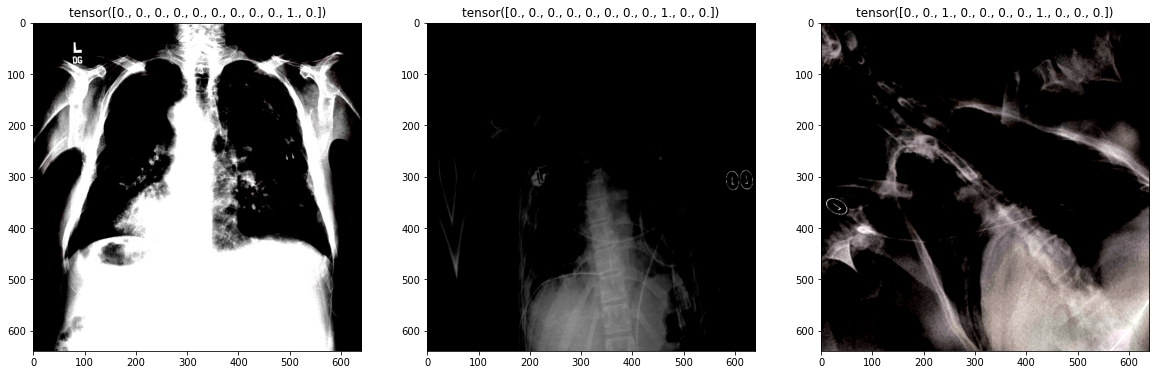

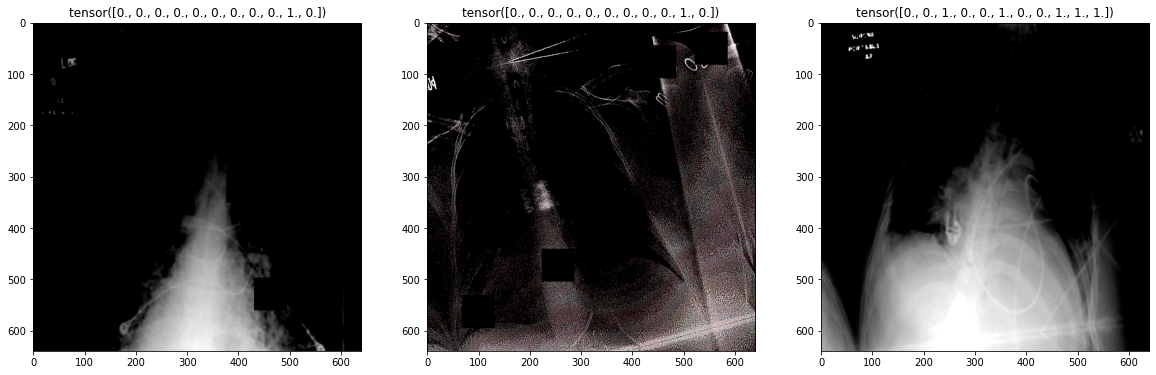

In [11]:
from pylab import rcParams
dataset_show = TrainDataset(train_df,
               transform=get_transforms(data='train') # None, get_transforms(data='check')
               )
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,3)
    for p in range(3):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        # axarr[p].imshow(img) # transform=None
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(label))

# Model

In [12]:
class RanzcrClassifier(nn.Module):
    def __init__(self, model_arch, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)

        if 'efficientnet' in CFG.model_arch:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, CFG.n_class)
        elif "resnet" in CFG.model_arch:
            n_features = self.model.fc.in_features
            self.model.global_pool = nn.Identity()
            self.model.fc = nn.Identity()
            self.pooling = nn.AdaptiveAvgPool2d(1)
            self.fc = nn.Linear(n_features, CFG.n_class)

    def forward(self, x):
        if 'efficientnet' in CFG.model_arch:
            return self.model(x)
        elif "resnet" in CFG.model_arch:
            bs = x.size(0)
            features = self.model(x)
            pooled_features = self.pooling(features).view(bs, -1)
            output = self.fc(pooled_features)
            return features, pooled_features, output

In [13]:
def get_activation(activ_name: str="relu"):
    """"""
    act_dict = {
        "relu": nn.ReLU(inplace=True),
        "tanh": nn.Tanh(),
        "sigmoid": nn.Sigmoid(),
        "identity": nn.Identity()}
    if activ_name in act_dict:
        return act_dict[activ_name]
    else:
        raise NotImplementedError
        

class Conv2dBNActiv(nn.Module):
    """Conv2d -> (BN ->) -> Activation"""
    
    def __init__(
        self, in_channels, out_channels,
        kernel_size, stride, padding,
        bias=False, use_bn=True, activ="relu"
    ):
        """"""
        super(Conv2dBNActiv, self).__init__()
        layers = []
        layers.append(nn.Conv2d(
            in_channels, out_channels,
            kernel_size, stride, padding, bias=bias))
        if use_bn:
            layers.append(nn.BatchNorm2d(out_channels))
            
        layers.append(get_activation(activ))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        """Forward"""
        return self.layers(x)
        
    
class SpatialAttentionBlock(nn.Module):
    """Spatial Attention for (C, H, W) feature maps"""
    
    def __init__(
        self, in_channels,
        out_channels_list,
    ):
        """Initialize"""
        super(SpatialAttentionBlock, self).__init__()
        self.n_layers = len(out_channels_list)
        channels_list = [in_channels] + out_channels_list
        assert self.n_layers > 0
        assert channels_list[-1] == 1
        
        for i in range(self.n_layers - 1):
            in_chs, out_chs = channels_list[i: i + 2]
            layer = Conv2dBNActiv(in_chs, out_chs, 3, 1, 1, activ="relu")
            setattr(self, f"conv{i + 1}", layer)
            
        in_chs, out_chs = channels_list[-2:]
        layer = Conv2dBNActiv(in_chs, out_chs, 3, 1, 1, activ="sigmoid")
        setattr(self, f"conv{self.n_layers}", layer)
    
    def forward(self, x):
        """Forward"""
        h = x
        for i in range(self.n_layers):
            h = getattr(self, f"conv{i + 1}")(h)
            
        h = h * x
        return h



class MultiHeadResNet200D(nn.Module):
    def __init__(self, out_dims_head=[3, 4, 3, 1],  pretrained=False):
        self.base_name = "resnet200d_320"
        self.n_heads = len(out_dims_head)
        super(MultiHeadResNet200D, self).__init__()
        
        # # load base model
        base_model = timm.create_model(self.base_name, num_classes=sum(out_dims_head), pretrained=False)
        in_features = base_model.num_features
        
        if pretrained:
            pretrained_model_path = CFG.student
            state_dict = dict()
            for k, v in torch.load(pretrained_model_path, map_location='cpu')["model"].items():
                if k[:6] == "model.":
                    k = k.replace("model.", "")
                state_dict[k] = v
            base_model.load_state_dict(state_dict)
        
        # # remove global pooling and head classifier
        base_model.reset_classifier(0, '')
        
        # # Shared CNN Bacbone
        self.backbone = base_model
        
        # # Multi Heads.
        for i, out_dim in enumerate(out_dims_head):
            layer_name = f"head_{i}"
            layer = nn.Sequential(
                SpatialAttentionBlock(in_features, [64, 32, 16, 1]),
                nn.AdaptiveAvgPool2d(output_size=1),
                nn.Flatten(start_dim=1),
                nn.Linear(in_features, in_features),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(in_features, out_dim))
            setattr(self, layer_name, layer)

    def forward(self, x):
        h = self.backbone(x)
        hs = [getattr(self, f"head_{i}")(h) for i in range(self.n_heads)]
        y = torch.cat(hs, axis=1)
        return None, None, y

In [14]:
def train_one_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'GPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        if CFG.device == 'GPU':
            with autocast():
                _, _, y_preds = model(images)
                loss = criterion(y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.accum_iter > 1:
                loss = loss / CFG.accum_iter
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.accum_iter == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        elif CFG.device == 'TPU':
            _, _, y_preds = model(images)
            loss = criterion(y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.accum_iter > 1:
                loss = loss / CFG.accum_iter
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.accum_iter == 0:
                xm.optimizer_step(optimizer, barrier=True)
                optimizer.zero_grad()
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            cusprint('Epoch: [{0}][{1}/{2}] '
                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                'Grad: {grad_norm:.4f}  '
                'LR: {lr:.7f}  '
                .format(
                epoch, step, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses,
                remain=timeSince(start, float(step+1)/len(train_loader)),
                grad_norm=grad_norm,
                lr=optimizer.param_groups[0]["lr"],
                ))

    return losses.avg, optimizer.param_groups[0]["lr"]

In [15]:
def valid_one_epoch(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    trues = []
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            _, _, y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        trues.append(labels.to('cpu').numpy())
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.accum_iter > 1:
            loss = loss / CFG.accum_iter
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            cusprint('EVAL: [{0}/{1}] '
                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                step, len(valid_loader), batch_time=batch_time,
                data_time=data_time, loss=losses,
                remain=timeSince(start, float(step+1)/len(valid_loader)),
                ))

    trues = np.concatenate(trues)
    predictions = np.concatenate(preds)
    return losses.avg, predictions, trues

# loss & optimizer & scheduler

In [16]:
class GradualWarmupSchedulerV3(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV3, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch >= self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

# Training

In [17]:
def train_loop(df, fold, trn_idx, val_idx):
    loginfo(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = train_df.loc[trn_idx].reset_index(drop=True)
    valid_folds = train_df.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='valid'))
    if CFG.device == 'GPU':
        train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, shuffle=True, num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, shuffle=False, num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    elif CFG.device == 'TPU':
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=True)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CFG.train_bs, sampler=train_sampler, drop_last=True, num_workers=CFG.num_workers)
        valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=False)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=CFG.valid_bs, sampler=valid_sampler, drop_last=False, num_workers=CFG.num_workers)

    # ====================================================
    # model & optimizer & scheduler & loss
    # ====================================================
    # not checkpoint

    if CFG.multihead:
        model = MultiHeadResNet200D([3, 4, 3, 1], True)
        # model.load_state_dict(torch.load(CFG.student)['model'])
    else:
        model = RanzcrClassifier(CFG.model_arch, pretrained=False)
        model.load_state_dict(torch.load(CFG.student)['model'])

        
    if CFG.gpu_parallel:    
        num_gpu = torch.cuda.device_count()
        model = DataParallel(model, device_ids=range(num_gpu))
    model.to(device)
    
    
    # optimizer
    if CFG.optimizer == "Adam":
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            optimizer = Adam(model.parameters(), lr=CFG.lr/CFG.warmup_factor, weight_decay=CFG.weight_decay) 
        else:
            optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    # scheduler
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)

    if CFG.scheduler_warmup=="GradualWarmupSchedulerV2":
        scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler)
    elif CFG.scheduler_warmup=="GradualWarmupSchedulerV3":
        scheduler_warmup = GradualWarmupSchedulerV3(optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler)

    # loss
    if CFG.loss_fn == "BCEWithLogitsLoss":
        criterion = nn.BCEWithLogitsLoss()

    # ====================================================
    # loop
    # ====================================================
    valid_acc_max=0; valid_loss_min=float("inf")
    valid_acc_max_cnt=0; valid_loss_min_cnt=0;
    best_acc_epoch=0;


    for epoch in range(CFG.epochs):
        loginfo(f"***** Epoch {epoch} *****")

        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            loginfo(f"schwarmup_last_epoch:{scheduler_warmup.last_epoch}, schwarmup_lr:{scheduler_warmup.get_last_lr()[0]}")
        if CFG.scheduler=='CosineAnnealingLR':
            loginfo(f"scheduler_last_epoch:{scheduler.last_epoch}, scheduler_lr:{scheduler.get_last_lr()[0]}")
        loginfo(f"optimizer_lr:{optimizer.param_groups[0]['lr']}")

                
        start_time = time.time()
        
        avg_loss, cur_lr = train_one_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device) # train
        avg_val_loss, preds, _ = valid_one_epoch(valid_loader, model, criterion, device) # valid

        # scoring
        score, scores = get_score(valid_labels, preds)
        elapsed = time.time() - start_time

        loginfo(f'Epoch {epoch} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        loginfo(f'Epoch {epoch} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')

        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            scheduler_warmup.step()
        elif CFG.scheduler == "ReduceLROnPlateau":
            scheduler.step(avg_val_loss)
        elif CFG.scheduler in ["CosineAnnealingLR", "CosineAnnealingWarmRestarts"]:
            scheduler.step()

        # early stopping
        if score > valid_acc_max:
            valid_acc_max = score
            valid_acc_max_cnt=0
            best_acc_epoch = epoch
        else:
            valid_acc_max_cnt+=1

        if avg_val_loss < valid_loss_min:
            valid_loss_min = avg_val_loss
            valid_loss_min_cnt=0
        else:
            valid_loss_min_cnt+=1

        if valid_acc_max_cnt >= CFG.n_early_stopping and valid_loss_min_cnt >= CFG.n_early_stopping:
            cur_best_list = [valid_acc_max, valid_loss_min, valid_acc_max_cnt, valid_loss_min_cnt, best_acc_epoch]
            if CFG.device == 'GPU':
                torch.save({'model': model.state_dict(), 'preds': preds, 'cur_best_list': cur_best_list}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
            elif CFG.device == 'TPU':
                xm.save({'model': model.state_dict(), 'preds': preds, 'cur_best_list': cur_best_list}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
            print("early_stopping")
            break

        cur_best_list = [valid_acc_max, valid_loss_min, valid_acc_max_cnt, valid_loss_min_cnt, best_acc_epoch]
        if CFG.device == 'GPU':
            torch.save({'model': model.state_dict(), 'preds': preds, 'cur_best_list': cur_best_list}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
        elif CFG.device == 'TPU':
            xm.save({'model': model.state_dict(), 'preds': preds, 'cur_best_list': cur_best_list}, outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')



    check_point = torch.load(outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{cur_best_list[4]}.pth')
    for c in [f'pred_{c}' for c in CFG.target_cols]:
        valid_folds[c] = np.nan
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']
    
    return valid_folds

In [18]:
def main():
    oof_df = pd.DataFrame()
    for fold, (trn_idx, val_idx) in enumerate(folds):
        if fold in CFG.fold_list:
            _oof_df = train_loop(train_df, fold, trn_idx, val_idx)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df)
                
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    oof_df.to_csv(outputdir+f'oof_df{CFG.suffix}.csv', index=False)

# Main

In [19]:
if __name__ == '__main__':
    print(CFG.suffix)
    if CFG.device == 'TPU':
        def _mp_fn(rank, flags):
            torch.set_default_tensor_type('torch.FloatTensor')
            a = main()
        FLAGS = {}
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=CFG.nprocs, start_method='fork')
    elif CFG.device == 'GPU':
        main()

========== fold: 3 training ==========


1013


***** Epoch 0 *****
scheduler_last_epoch:0, scheduler_lr:0.0001
optimizer_lr:0.0001


Epoch: [0][0/2005] Data 4.358 (4.358) Elapsed 0m 7s (remain 247m 17s) Loss: 0.7165(0.7165) Grad: 121824.0234  LR: 0.0001000  
Epoch: [0][100/2005] Data 0.000 (0.043) Elapsed 1m 5s (remain 20m 36s) Loss: 0.2029(0.2386) Grad: 69123.8672  LR: 0.0001000  
Epoch: [0][200/2005] Data 0.000 (0.022) Elapsed 2m 3s (remain 18m 30s) Loss: 0.1484(0.2207) Grad: 34809.1953  LR: 0.0001000  
Epoch: [0][300/2005] Data 0.000 (0.015) Elapsed 3m 2s (remain 17m 13s) Loss: 0.1363(0.2169) Grad: 37301.5234  LR: 0.0001000  
Epoch: [0][400/2005] Data 0.000 (0.011) Elapsed 4m 0s (remain 16m 2s) Loss: 0.1260(0.2121) Grad: 50146.1914  LR: 0.0001000  
Epoch: [0][500/2005] Data 0.000 (0.009) Elapsed 4m 58s (remain 14m 56s) Loss: 0.1917(0.2124) Grad: 44349.1797  LR: 0.0001000  
Epoch: [0][600/2005] Data 0.000 (0.008) Elapsed 5m 56s (remain 13m 52s) Loss: 0.1548(0.2096) Grad: 42342.6836  LR: 0.0001000  
Epoch: [0][700/2005] Data 0.000 (0.006) Elapsed 6m 54s (remain 12m 50s) Loss: 0.1597(0.2076) Grad: 40216.6602  LR: 0.

Epoch 0 - avg_train_loss: 0.1958  avg_val_loss: 0.1415  time: 1318s
Epoch 0 - Score: 0.9441  Scores: [0.9824 0.9595 0.9926 0.9418 0.9207 0.9798 0.9886 0.8865 0.8374 0.9039
 0.9919]
***** Epoch 1 *****
scheduler_last_epoch:1, scheduler_lr:9.915716843435315e-05
optimizer_lr:9.915716843435315e-05


Epoch: [1][0/2005] Data 4.118 (4.118) Elapsed 0m 5s (remain 171m 10s) Loss: 0.1971(0.1971) Grad: 43449.0586  LR: 0.0000992  
Epoch: [1][100/2005] Data 0.000 (0.041) Elapsed 1m 3s (remain 20m 0s) Loss: 0.1695(0.1888) Grad: 35281.1602  LR: 0.0000992  
Epoch: [1][200/2005] Data 0.002 (0.021) Elapsed 2m 0s (remain 18m 5s) Loss: 0.1671(0.1844) Grad: 34609.7617  LR: 0.0000992  
Epoch: [1][300/2005] Data 0.000 (0.014) Elapsed 2m 59s (remain 16m 57s) Loss: 0.2620(0.1836) Grad: 74507.0312  LR: 0.0000992  
Epoch: [1][400/2005] Data 0.000 (0.011) Elapsed 3m 57s (remain 15m 48s) Loss: 0.1498(0.1841) Grad: 34238.6094  LR: 0.0000992  
Epoch: [1][500/2005] Data 0.000 (0.008) Elapsed 4m 56s (remain 14m 49s) Loss: 0.1090(0.1856) Grad: 32279.1738  LR: 0.0000992  
Epoch: [1][600/2005] Data 0.000 (0.007) Elapsed 5m 54s (remain 13m 47s) Loss: 0.1021(0.1845) Grad: 27747.2773  LR: 0.0000992  
Epoch: [1][700/2005] Data 0.000 (0.006) Elapsed 6m 52s (remain 12m 46s) Loss: 0.1505(0.1847) Grad: 32957.2305  LR: 0.

Epoch 1 - avg_train_loss: 0.1783  avg_val_loss: 0.1302  time: 1299s
Epoch 1 - Score: 0.9506  Scores: [0.9719 0.9607 0.9918 0.9531 0.9475 0.9848 0.9873 0.8946 0.8574 0.9096
 0.9984]


EVAL: [214/215] Data 0.000 (0.015) Elapsed 2m 13s (remain 0m 0s) Loss: 0.1812(0.1302) 


***** Epoch 2 *****
scheduler_last_epoch:2, scheduler_lr:9.665737535551561e-05
optimizer_lr:9.665737535551561e-05


Epoch: [2][0/2005] Data 6.082 (6.082) Elapsed 0m 6s (remain 226m 58s) Loss: 0.2157(0.2157) Grad: 53725.0977  LR: 0.0000967  
Epoch: [2][100/2005] Data 0.000 (0.060) Elapsed 1m 5s (remain 20m 29s) Loss: 0.2891(0.1814) Grad: 60756.7734  LR: 0.0000967  
Epoch: [2][200/2005] Data 0.000 (0.031) Elapsed 2m 3s (remain 18m 25s) Loss: 0.1721(0.1787) Grad: 36428.9414  LR: 0.0000967  
Epoch: [2][300/2005] Data 0.000 (0.020) Elapsed 2m 59s (remain 16m 58s) Loss: 0.1296(0.1739) Grad: 32306.2754  LR: 0.0000967  
Epoch: [2][400/2005] Data 0.000 (0.015) Elapsed 3m 57s (remain 15m 48s) Loss: 0.2058(0.1719) Grad: 45781.4102  LR: 0.0000967  
Epoch: [2][500/2005] Data 0.000 (0.012) Elapsed 4m 55s (remain 14m 45s) Loss: 0.1363(0.1722) Grad: 31788.1953  LR: 0.0000967  
Epoch: [2][600/2005] Data 0.000 (0.010) Elapsed 5m 52s (remain 13m 43s) Loss: 0.1622(0.1705) Grad: 37292.1250  LR: 0.0000967  
Epoch: [2][700/2005] Data 0.000 (0.009) Elapsed 6m 50s (remain 12m 42s) Loss: 0.2046(0.1704) Grad: 57429.5117  LR: 

Epoch 2 - avg_train_loss: 0.1689  avg_val_loss: 0.1342  time: 1297s
Epoch 2 - Score: 0.9498  Scores: [0.9851 0.963  0.993  0.9563 0.9486 0.9814 0.9874 0.8819 0.8584 0.8956
 0.9973]


EVAL: [214/215] Data 0.000 (0.015) Elapsed 2m 13s (remain 0m 0s) Loss: 0.2128(0.1342) 


***** Epoch 3 *****
scheduler_last_epoch:3, scheduler_lr:9.258574821861591e-05
optimizer_lr:9.258574821861591e-05


Epoch: [3][0/2005] Data 4.700 (4.700) Elapsed 0m 5s (remain 179m 45s) Loss: 0.1368(0.1368) Grad: 34847.3789  LR: 0.0000926  
Epoch: [3][100/2005] Data 0.000 (0.047) Elapsed 1m 4s (remain 20m 10s) Loss: 0.0774(0.1586) Grad: 45702.4258  LR: 0.0000926  
Epoch: [3][200/2005] Data 0.000 (0.024) Elapsed 2m 2s (remain 18m 16s) Loss: 0.1657(0.1592) Grad: 35837.4844  LR: 0.0000926  
Epoch: [3][300/2005] Data 0.000 (0.016) Elapsed 3m 0s (remain 16m 59s) Loss: 0.1132(0.1631) Grad: 30663.0410  LR: 0.0000926  
Epoch: [3][400/2005] Data 0.000 (0.012) Elapsed 3m 57s (remain 15m 50s) Loss: 0.1166(0.1633) Grad: 34165.9570  LR: 0.0000926  
Epoch: [3][500/2005] Data 0.000 (0.010) Elapsed 4m 55s (remain 14m 47s) Loss: 0.1752(0.1618) Grad: 34443.6641  LR: 0.0000926  
Epoch: [3][600/2005] Data 0.000 (0.008) Elapsed 5m 53s (remain 13m 45s) Loss: 0.1347(0.1615) Grad: 43477.1641  LR: 0.0000926  
Epoch: [3][700/2005] Data 0.000 (0.007) Elapsed 6m 51s (remain 12m 45s) Loss: 0.0838(0.1625) Grad: 27869.3223  LR: 0

Epoch 3 - avg_train_loss: 0.1627  avg_val_loss: 0.1260  time: 1300s
Epoch 3 - Score: 0.9548  Scores: [0.9843 0.9656 0.9938 0.9661 0.9526 0.9865 0.9897 0.9077 0.8524 0.906
 0.9985]


EVAL: [214/215] Data 0.000 (0.015) Elapsed 2m 13s (remain 0m 0s) Loss: 0.2057(0.1260) 


***** Epoch 4 *****
scheduler_last_epoch:4, scheduler_lr:8.708094140242264e-05
optimizer_lr:8.708094140242264e-05


Epoch: [4][0/2005] Data 2.273 (2.273) Elapsed 0m 3s (remain 104m 10s) Loss: 0.1191(0.1191) Grad: 25636.8730  LR: 0.0000871  
Epoch: [4][100/2005] Data 0.000 (0.024) Elapsed 1m 3s (remain 19m 49s) Loss: 0.1012(0.1513) Grad: 50234.5078  LR: 0.0000871  
Epoch: [4][200/2005] Data 0.000 (0.012) Elapsed 2m 1s (remain 18m 9s) Loss: 0.1447(0.1545) Grad: 41469.7227  LR: 0.0000871  
Epoch: [4][300/2005] Data 0.000 (0.008) Elapsed 2m 58s (remain 16m 51s) Loss: 0.2078(0.1566) Grad: 43185.6562  LR: 0.0000871  
Epoch: [4][400/2005] Data 0.000 (0.006) Elapsed 3m 56s (remain 15m 47s) Loss: 0.1473(0.1587) Grad: 22972.0566  LR: 0.0000871  
Epoch: [4][500/2005] Data 0.000 (0.005) Elapsed 4m 55s (remain 14m 47s) Loss: 0.1130(0.1565) Grad: 26990.7168  LR: 0.0000871  
Epoch: [4][600/2005] Data 0.000 (0.004) Elapsed 5m 53s (remain 13m 44s) Loss: 0.0777(0.1552) Grad: 24128.7988  LR: 0.0000871  
Epoch: [4][700/2005] Data 0.000 (0.004) Elapsed 6m 51s (remain 12m 45s) Loss: 0.1471(0.1553) Grad: 41798.9570  LR: 0

Epoch 4 - avg_train_loss: 0.1580  avg_val_loss: 0.1266  time: 1298s
Epoch 4 - Score: 0.9565  Scores: [0.9817 0.963  0.993  0.9643 0.949  0.982  0.987  0.9122 0.8741 0.9187
 0.9965]


EVAL: [214/215] Data 0.000 (0.015) Elapsed 2m 13s (remain 0m 0s) Loss: 0.1802(0.1266) 


***** Epoch 5 *****
scheduler_last_epoch:5, scheduler_lr:8.033041450077321e-05
optimizer_lr:8.033041450077321e-05


Epoch: [5][0/2005] Data 5.200 (5.200) Elapsed 0m 5s (remain 196m 20s) Loss: 0.1336(0.1336) Grad: 23394.2070  LR: 0.0000803  
Epoch: [5][100/2005] Data 0.000 (0.052) Elapsed 1m 5s (remain 20m 31s) Loss: 0.1289(0.1626) Grad: 39357.5000  LR: 0.0000803  
Epoch: [5][200/2005] Data 0.000 (0.026) Elapsed 2m 3s (remain 18m 28s) Loss: 0.1160(0.1582) Grad: 30546.3555  LR: 0.0000803  
Epoch: [5][300/2005] Data 0.000 (0.018) Elapsed 3m 0s (remain 17m 2s) Loss: 0.1050(0.1548) Grad: 29100.1074  LR: 0.0000803  
Epoch: [5][400/2005] Data 0.000 (0.013) Elapsed 3m 58s (remain 15m 55s) Loss: 0.0949(0.1555) Grad: 22009.5215  LR: 0.0000803  
Epoch: [5][500/2005] Data 0.000 (0.011) Elapsed 4m 56s (remain 14m 51s) Loss: 0.0781(0.1546) Grad: 20573.5957  LR: 0.0000803  
Epoch: [5][600/2005] Data 0.000 (0.009) Elapsed 5m 54s (remain 13m 48s) Loss: 0.2301(0.1545) Grad: 29935.8672  LR: 0.0000803  
Epoch: [5][700/2005] Data 0.000 (0.008) Elapsed 6m 53s (remain 12m 49s) Loss: 0.3534(0.1545) Grad: 52721.9492  LR: 0.

Epoch 5 - avg_train_loss: 0.1532  avg_val_loss: 0.1224  time: 1305s
Epoch 5 - Score: 0.9592  Scores: [0.9861 0.9628 0.9926 0.9727 0.9629 0.988  0.9903 0.9121 0.8706 0.9173
 0.9958]


EVAL: [214/215] Data 0.000 (0.015) Elapsed 2m 13s (remain 0m 0s) Loss: 0.1846(0.1224) 


***** Epoch 6 *****
scheduler_last_epoch:6, scheduler_lr:7.256404861093866e-05
optimizer_lr:7.256404861093866e-05


Epoch: [6][0/2005] Data 4.571 (4.571) Elapsed 0m 5s (remain 174m 7s) Loss: 0.1440(0.1440) Grad: 27088.6797  LR: 0.0000726  
Epoch: [6][100/2005] Data 0.000 (0.046) Elapsed 1m 4s (remain 20m 10s) Loss: 0.1488(0.1502) Grad: 32830.8438  LR: 0.0000726  
Epoch: [6][200/2005] Data 0.000 (0.023) Elapsed 2m 2s (remain 18m 15s) Loss: 0.1712(0.1521) Grad: 66196.9609  LR: 0.0000726  
Epoch: [6][300/2005] Data 0.000 (0.015) Elapsed 3m 0s (remain 17m 2s) Loss: 0.1745(0.1518) Grad: 47032.0117  LR: 0.0000726  
Epoch: [6][400/2005] Data 0.000 (0.012) Elapsed 3m 58s (remain 15m 52s) Loss: 0.1487(0.1488) Grad: 30902.3340  LR: 0.0000726  
Epoch: [6][500/2005] Data 0.000 (0.009) Elapsed 4m 57s (remain 14m 51s) Loss: 0.1701(0.1494) Grad: 46380.7695  LR: 0.0000726  
Epoch: [6][600/2005] Data 0.000 (0.008) Elapsed 5m 56s (remain 13m 52s) Loss: 0.2522(0.1486) Grad: 44794.9062  LR: 0.0000726  
Epoch: [6][700/2005] Data 0.000 (0.007) Elapsed 6m 54s (remain 12m 51s) Loss: 0.1821(0.1482) Grad: 36602.8672  LR: 0.0

Epoch 6 - avg_train_loss: 0.1482  avg_val_loss: 0.1202  time: 1310s
Epoch 6 - Score: 0.9612  Scores: [0.9924 0.9644 0.9936 0.9834 0.9606 0.9868 0.9899 0.9157 0.8717 0.9187
 0.9959]


EVAL: [214/215] Data 0.000 (0.016) Elapsed 2m 13s (remain 0m 0s) Loss: 0.1794(0.1202) 


***** Epoch 7 *****
scheduler_last_epoch:7, scheduler_lr:6.404631800856812e-05
optimizer_lr:6.404631800856812e-05


Epoch: [7][0/2005] Data 3.421 (3.421) Elapsed 0m 4s (remain 138m 50s) Loss: 0.1472(0.1472) Grad: 28658.7109  LR: 0.0000640  
Epoch: [7][100/2005] Data 0.000 (0.038) Elapsed 1m 3s (remain 19m 57s) Loss: 0.1624(0.1387) Grad: 51363.1719  LR: 0.0000640  
Epoch: [7][200/2005] Data 0.000 (0.019) Elapsed 2m 2s (remain 18m 23s) Loss: 0.1299(0.1458) Grad: 31883.9688  LR: 0.0000640  
Epoch: [7][300/2005] Data 0.000 (0.013) Elapsed 3m 0s (remain 17m 4s) Loss: 0.0664(0.1440) Grad: 22871.4766  LR: 0.0000640  
Epoch: [7][400/2005] Data 0.000 (0.010) Elapsed 3m 58s (remain 15m 52s) Loss: 0.1839(0.1457) Grad: 43685.0117  LR: 0.0000640  
Epoch: [7][500/2005] Data 0.000 (0.008) Elapsed 4m 57s (remain 14m 51s) Loss: 0.1531(0.1443) Grad: 34706.1328  LR: 0.0000640  
Epoch: [7][600/2005] Data 0.000 (0.007) Elapsed 5m 55s (remain 13m 50s) Loss: 0.1889(0.1439) Grad: 47879.1797  LR: 0.0000640  
Epoch: [7][700/2005] Data 0.000 (0.006) Elapsed 6m 54s (remain 12m 50s) Loss: 0.2107(0.1446) Grad: 46418.4297  LR: 0.

Epoch 7 - avg_train_loss: 0.1444  avg_val_loss: 0.1177  time: 1309s
Epoch 7 - Score: 0.9619  Scores: [0.9959 0.9641 0.9933 0.9803 0.9563 0.9878 0.9902 0.9147 0.8792 0.9226
 0.9972]


EVAL: [214/215] Data 0.000 (0.016) Elapsed 2m 13s (remain 0m 0s) Loss: 0.1809(0.1177) 


***** Epoch 8 *****
scheduler_last_epoch:8, scheduler_lr:5.5067283793433455e-05
optimizer_lr:5.5067283793433455e-05


Epoch: [8][0/2005] Data 3.842 (3.842) Elapsed 0m 4s (remain 149m 52s) Loss: 0.0599(0.0599) Grad: 20875.7969  LR: 0.0000551  
Epoch: [8][100/2005] Data 0.000 (0.038) Elapsed 1m 4s (remain 20m 12s) Loss: 0.1908(0.1350) Grad: 49398.5859  LR: 0.0000551  
Epoch: [8][200/2005] Data 0.000 (0.019) Elapsed 2m 1s (remain 18m 14s) Loss: 0.1236(0.1398) Grad: 21974.2207  LR: 0.0000551  
Epoch: [8][300/2005] Data 0.000 (0.013) Elapsed 3m 0s (remain 17m 1s) Loss: 0.1552(0.1387) Grad: 36327.2969  LR: 0.0000551  
Epoch: [8][400/2005] Data 0.000 (0.010) Elapsed 3m 59s (remain 15m 57s) Loss: 0.0920(0.1374) Grad: 30094.5664  LR: 0.0000551  
Epoch: [8][500/2005] Data 0.000 (0.008) Elapsed 4m 58s (remain 14m 55s) Loss: 0.1321(0.1392) Grad: 44097.0469  LR: 0.0000551  
Epoch: [8][600/2005] Data 0.000 (0.007) Elapsed 5m 56s (remain 13m 53s) Loss: 0.0990(0.1396) Grad: 26848.3750  LR: 0.0000551  
Epoch: [8][700/2005] Data 0.000 (0.006) Elapsed 6m 54s (remain 12m 50s) Loss: 0.1694(0.1392) Grad: 46845.8711  LR: 0.

Epoch 8 - avg_train_loss: 0.1405  avg_val_loss: 0.1181  time: 1307s
Epoch 8 - Score: 0.9631  Scores: [0.9964 0.9673 0.9936 0.9785 0.9548 0.9863 0.991  0.9221 0.8833 0.9225
 0.9979]


EVAL: [214/215] Data 0.000 (0.016) Elapsed 2m 13s (remain 0m 0s) Loss: 0.1916(0.1181) 


***** Epoch 9 *****
scheduler_last_epoch:9, scheduler_lr:4.5932716206566554e-05
optimizer_lr:4.5932716206566554e-05


Epoch: [9][0/2005] Data 2.312 (2.312) Elapsed 0m 3s (remain 101m 20s) Loss: 0.0877(0.0877) Grad: 41931.1445  LR: 0.0000459  
Epoch: [9][100/2005] Data 0.000 (0.050) Elapsed 1m 4s (remain 20m 11s) Loss: 0.2111(0.1314) Grad: 50234.3672  LR: 0.0000459  
Epoch: [9][200/2005] Data 0.000 (0.025) Elapsed 2m 1s (remain 18m 12s) Loss: 0.1922(0.1367) Grad: 57959.6211  LR: 0.0000459  
Epoch: [9][300/2005] Data 0.000 (0.017) Elapsed 3m 0s (remain 17m 2s) Loss: 0.1262(0.1352) Grad: 37772.7109  LR: 0.0000459  
Epoch: [9][400/2005] Data 0.000 (0.013) Elapsed 3m 57s (remain 15m 51s) Loss: 0.1440(0.1363) Grad: 58273.6797  LR: 0.0000459  
Epoch: [9][500/2005] Data 0.000 (0.010) Elapsed 4m 56s (remain 14m 49s) Loss: 0.0777(0.1366) Grad: 27583.0020  LR: 0.0000459  
Epoch: [9][600/2005] Data 0.000 (0.009) Elapsed 5m 54s (remain 13m 48s) Loss: 0.1241(0.1366) Grad: 56908.7266  LR: 0.0000459  
Epoch: [9][700/2005] Data 0.000 (0.007) Elapsed 6m 53s (remain 12m 48s) Loss: 0.0907(0.1365) Grad: 31033.3555  LR: 0.

Epoch 9 - avg_train_loss: 0.1369  avg_val_loss: 0.1192  time: 1305s
Epoch 9 - Score: 0.9641  Scores: [0.9973 0.9662 0.9939 0.9823 0.9581 0.9878 0.9908 0.9227 0.8839 0.9255
 0.9966]


EVAL: [214/215] Data 0.000 (0.015) Elapsed 2m 13s (remain 0m 0s) Loss: 0.1950(0.1192) 


***** Epoch 10 *****
scheduler_last_epoch:10, scheduler_lr:3.69536819914319e-05
optimizer_lr:3.69536819914319e-05


Epoch: [10][0/2005] Data 4.145 (4.145) Elapsed 0m 4s (remain 165m 8s) Loss: 0.2318(0.2318) Grad: 55359.1875  LR: 0.0000370  
Epoch: [10][100/2005] Data 0.000 (0.041) Elapsed 1m 4s (remain 20m 9s) Loss: 0.1446(0.1258) Grad: 29159.0449  LR: 0.0000370  
Epoch: [10][200/2005] Data 0.000 (0.021) Elapsed 2m 1s (remain 18m 14s) Loss: 0.0912(0.1282) Grad: 26689.4980  LR: 0.0000370  
Epoch: [10][300/2005] Data 0.000 (0.014) Elapsed 3m 0s (remain 16m 59s) Loss: 0.1219(0.1303) Grad: 25940.7012  LR: 0.0000370  
Epoch: [10][400/2005] Data 0.000 (0.011) Elapsed 3m 57s (remain 15m 51s) Loss: 0.0824(0.1313) Grad: 33521.7031  LR: 0.0000370  
Epoch: [10][500/2005] Data 0.000 (0.009) Elapsed 4m 56s (remain 14m 48s) Loss: 0.1125(0.1323) Grad: 30570.1133  LR: 0.0000370  
Epoch: [10][600/2005] Data 0.000 (0.007) Elapsed 5m 53s (remain 13m 45s) Loss: 0.1215(0.1306) Grad: 41474.3164  LR: 0.0000370  
Epoch: [10][700/2005] Data 0.000 (0.006) Elapsed 6m 51s (remain 12m 46s) Loss: 0.0761(0.1312) Grad: 33245.4141 

Epoch 10 - avg_train_loss: 0.1326  avg_val_loss: 0.1175  time: 1305s
Epoch 10 - Score: 0.9652  Scores: [0.9971 0.968  0.9942 0.9865 0.9645 0.9882 0.9905 0.9251 0.8821 0.9252
 0.9956]


EVAL: [214/215] Data 0.000 (0.015) Elapsed 2m 13s (remain 0m 0s) Loss: 0.2102(0.1175) 


***** Epoch 11 *****
scheduler_last_epoch:11, scheduler_lr:2.8435951389061382e-05
optimizer_lr:2.8435951389061382e-05


Epoch: [11][0/2005] Data 4.200 (4.200) Elapsed 0m 4s (remain 165m 5s) Loss: 0.1944(0.1944) Grad: 39587.8281  LR: 0.0000284  
Epoch: [11][100/2005] Data 0.000 (0.042) Elapsed 1m 3s (remain 20m 0s) Loss: 0.2044(0.1299) Grad: 36535.5547  LR: 0.0000284  
Epoch: [11][200/2005] Data 0.000 (0.021) Elapsed 2m 2s (remain 18m 21s) Loss: 0.1748(0.1318) Grad: 39262.1406  LR: 0.0000284  
Epoch: [11][300/2005] Data 0.000 (0.014) Elapsed 3m 0s (remain 17m 0s) Loss: 0.1840(0.1315) Grad: 42539.0195  LR: 0.0000284  
Epoch: [11][400/2005] Data 0.000 (0.011) Elapsed 3m 59s (remain 15m 57s) Loss: 0.1104(0.1320) Grad: 42335.1367  LR: 0.0000284  
Epoch: [11][500/2005] Data 0.000 (0.009) Elapsed 4m 57s (remain 14m 51s) Loss: 0.1284(0.1301) Grad: 37221.7812  LR: 0.0000284  
Epoch: [11][600/2005] Data 0.000 (0.007) Elapsed 5m 54s (remain 13m 48s) Loss: 0.0721(0.1305) Grad: 31093.9922  LR: 0.0000284  
Epoch: [11][700/2005] Data 0.000 (0.006) Elapsed 6m 52s (remain 12m 47s) Loss: 0.1219(0.1307) Grad: 33941.2695  

Epoch 11 - avg_train_loss: 0.1293  avg_val_loss: 0.1196  time: 1306s
Epoch 11 - Score: 0.9658  Scores: [0.9976 0.9668 0.9937 0.985  0.9627 0.9878 0.9905 0.9307 0.886  0.9269
 0.9963]


EVAL: [214/215] Data 0.000 (0.015) Elapsed 2m 13s (remain 0m 0s) Loss: 0.1974(0.1196) 


***** Epoch 12 *****
scheduler_last_epoch:12, scheduler_lr:2.0669585499226815e-05
optimizer_lr:2.0669585499226815e-05


Epoch: [12][0/2005] Data 5.118 (5.118) Elapsed 0m 5s (remain 198m 3s) Loss: 0.2366(0.2366) Grad: 58071.7227  LR: 0.0000207  
Epoch: [12][100/2005] Data 0.000 (0.051) Elapsed 1m 4s (remain 20m 23s) Loss: 0.1584(0.1229) Grad: 47101.8086  LR: 0.0000207  
Epoch: [12][200/2005] Data 0.006 (0.026) Elapsed 2m 3s (remain 18m 29s) Loss: 0.1790(0.1295) Grad: 69388.9531  LR: 0.0000207  
Epoch: [12][300/2005] Data 0.000 (0.017) Elapsed 3m 2s (remain 17m 12s) Loss: 0.0709(0.1280) Grad: 29650.5859  LR: 0.0000207  
Epoch: [12][400/2005] Data 0.000 (0.013) Elapsed 4m 0s (remain 16m 3s) Loss: 0.1235(0.1270) Grad: 48993.1094  LR: 0.0000207  
Epoch: [12][500/2005] Data 0.000 (0.011) Elapsed 4m 59s (remain 14m 57s) Loss: 0.1302(0.1262) Grad: 44873.1328  LR: 0.0000207  
Epoch: [12][600/2005] Data 0.000 (0.009) Elapsed 5m 57s (remain 13m 55s) Loss: 0.1931(0.1271) Grad: 46888.3242  LR: 0.0000207  
Epoch: [12][700/2005] Data 0.000 (0.008) Elapsed 6m 56s (remain 12m 54s) Loss: 0.1075(0.1272) Grad: 42411.0117  

Epoch 12 - avg_train_loss: 0.1271  avg_val_loss: 0.1183  time: 1307s
Epoch 12 - Score: 0.9656  Scores: [0.9988 0.9669 0.9936 0.985  0.964  0.9882 0.991  0.9278 0.8835 0.9257
 0.9966]


EVAL: [214/215] Data 0.000 (0.015) Elapsed 2m 13s (remain 0m 0s) Loss: 0.2157(0.1183) 


***** Epoch 13 *****
scheduler_last_epoch:13, scheduler_lr:1.3919058597577366e-05
optimizer_lr:1.3919058597577366e-05


Epoch: [13][0/2005] Data 3.095 (3.095) Elapsed 0m 3s (remain 125m 2s) Loss: 0.1224(0.1224) Grad: 37532.3711  LR: 0.0000139  
Epoch: [13][100/2005] Data 0.000 (0.038) Elapsed 1m 3s (remain 20m 3s) Loss: 0.1250(0.1234) Grad: 52039.8438  LR: 0.0000139  
Epoch: [13][200/2005] Data 0.000 (0.019) Elapsed 2m 2s (remain 18m 18s) Loss: 0.1317(0.1239) Grad: 46381.7383  LR: 0.0000139  
Epoch: [13][300/2005] Data 0.000 (0.013) Elapsed 3m 1s (remain 17m 6s) Loss: 0.0994(0.1233) Grad: 36722.0547  LR: 0.0000139  
Epoch: [13][400/2005] Data 0.000 (0.010) Elapsed 3m 59s (remain 15m 56s) Loss: 0.0923(0.1245) Grad: 32272.1230  LR: 0.0000139  
Epoch: [13][500/2005] Data 0.000 (0.008) Elapsed 4m 57s (remain 14m 52s) Loss: 0.1741(0.1245) Grad: 42085.6836  LR: 0.0000139  
Epoch: [13][600/2005] Data 0.000 (0.007) Elapsed 5m 55s (remain 13m 50s) Loss: 0.1371(0.1237) Grad: 46026.8555  LR: 0.0000139  
Epoch: [13][700/2005] Data 0.000 (0.006) Elapsed 6m 53s (remain 12m 48s) Loss: 0.0840(0.1240) Grad: 30627.1172  

Epoch 13 - avg_train_loss: 0.1242  avg_val_loss: 0.1216  time: 1304s
Epoch 13 - Score: 0.9659  Scores: [0.998  0.967  0.9937 0.9855 0.9642 0.9886 0.9911 0.9302 0.8846 0.926
 0.9959]


EVAL: [214/215] Data 0.000 (0.015) Elapsed 2m 13s (remain 0m 0s) Loss: 0.2205(0.1216) 


***** Epoch 14 *****
scheduler_last_epoch:14, scheduler_lr:8.414251781384107e-06
optimizer_lr:8.414251781384107e-06


Epoch: [14][0/2005] Data 4.653 (4.653) Elapsed 0m 5s (remain 176m 35s) Loss: 0.1614(0.1614) Grad: 54128.7812  LR: 0.0000084  
Epoch: [14][100/2005] Data 0.000 (0.048) Elapsed 1m 4s (remain 20m 13s) Loss: 0.1790(0.1286) Grad: 46660.1719  LR: 0.0000084  
Epoch: [14][200/2005] Data 0.000 (0.024) Elapsed 2m 3s (remain 18m 26s) Loss: 0.1284(0.1255) Grad: 45913.5312  LR: 0.0000084  
Epoch: [14][300/2005] Data 0.000 (0.016) Elapsed 3m 1s (remain 17m 10s) Loss: 0.0505(0.1218) Grad: 28360.9492  LR: 0.0000084  
Epoch: [14][400/2005] Data 0.000 (0.012) Elapsed 3m 59s (remain 15m 58s) Loss: 0.1115(0.1223) Grad: 39339.0781  LR: 0.0000084  
Epoch: [14][500/2005] Data 0.000 (0.010) Elapsed 4m 57s (remain 14m 52s) Loss: 0.1348(0.1223) Grad: 44310.0391  LR: 0.0000084  
Epoch: [14][600/2005] Data 0.000 (0.008) Elapsed 5m 55s (remain 13m 50s) Loss: 0.1423(0.1208) Grad: 47969.3672  LR: 0.0000084  
Epoch: [14][700/2005] Data 0.000 (0.007) Elapsed 6m 54s (remain 12m 50s) Loss: 0.0649(0.1199) Grad: 35439.902

Epoch 14 - avg_train_loss: 0.1221  avg_val_loss: 0.1208  time: 1308s
Epoch 14 - Score: 0.9662  Scores: [0.9984 0.9688 0.9941 0.984  0.9662 0.9882 0.991  0.9307 0.8844 0.9257
 0.9969]


EVAL: [214/215] Data 0.000 (0.015) Elapsed 2m 13s (remain 0m 0s) Loss: 0.2118(0.1208) 


***** Epoch 15 *****
scheduler_last_epoch:15, scheduler_lr:4.3426246444843925e-06
optimizer_lr:4.3426246444843925e-06


Epoch: [15][0/2005] Data 5.345 (5.345) Elapsed 0m 5s (remain 200m 8s) Loss: 0.1666(0.1666) Grad: 64178.3281  LR: 0.0000043  
Epoch: [15][100/2005] Data 0.000 (0.056) Elapsed 1m 4s (remain 20m 13s) Loss: 0.1301(0.1237) Grad: 74644.2344  LR: 0.0000043  
Epoch: [15][200/2005] Data 0.000 (0.028) Elapsed 2m 3s (remain 18m 29s) Loss: 0.1186(0.1254) Grad: 35766.6875  LR: 0.0000043  
Epoch: [15][300/2005] Data 0.000 (0.019) Elapsed 3m 1s (remain 17m 6s) Loss: 0.1304(0.1251) Grad: 37118.3789  LR: 0.0000043  
Epoch: [15][400/2005] Data 0.000 (0.014) Elapsed 4m 0s (remain 16m 1s) Loss: 0.1023(0.1232) Grad: 45600.9531  LR: 0.0000043  
Epoch: [15][500/2005] Data 0.000 (0.012) Elapsed 4m 58s (remain 14m 56s) Loss: 0.1433(0.1219) Grad: 64907.6641  LR: 0.0000043  
Epoch: [15][600/2005] Data 0.000 (0.010) Elapsed 5m 56s (remain 13m 53s) Loss: 0.1315(0.1221) Grad: 42498.4453  LR: 0.0000043  
Epoch: [15][700/2005] Data 0.000 (0.008) Elapsed 6m 54s (remain 12m 51s) Loss: 0.0602(0.1215) Grad: 28931.6426  L

Epoch 15 - avg_train_loss: 0.1193  avg_val_loss: 0.1199  time: 1307s
Epoch 15 - Score: 0.9666  Scores: [0.9985 0.9699 0.9942 0.9845 0.9661 0.9886 0.9911 0.9316 0.8845 0.9261
 0.9972]


EVAL: [214/215] Data 0.000 (0.016) Elapsed 2m 13s (remain 0m 0s) Loss: 0.1966(0.1199) 


***** Epoch 16 *****
scheduler_last_epoch:16, scheduler_lr:1.8428315656468617e-06
optimizer_lr:1.8428315656468617e-06


Epoch: [16][0/2005] Data 6.083 (6.083) Elapsed 0m 6s (remain 225m 8s) Loss: 0.0923(0.0923) Grad: 80166.7656  LR: 0.0000018  
Epoch: [16][100/2005] Data 0.000 (0.060) Elapsed 1m 5s (remain 20m 30s) Loss: 0.0694(0.1183) Grad: 34162.2969  LR: 0.0000018  
Epoch: [16][200/2005] Data 0.000 (0.031) Elapsed 2m 4s (remain 18m 33s) Loss: 0.1202(0.1201) Grad: 41890.3555  LR: 0.0000018  
Epoch: [16][300/2005] Data 0.000 (0.020) Elapsed 3m 1s (remain 17m 10s) Loss: 0.0655(0.1207) Grad: 21458.9043  LR: 0.0000018  
Epoch: [16][400/2005] Data 0.000 (0.015) Elapsed 4m 0s (remain 16m 1s) Loss: 0.1234(0.1208) Grad: 78635.0000  LR: 0.0000018  
Epoch: [16][500/2005] Data 0.000 (0.012) Elapsed 4m 58s (remain 14m 54s) Loss: 0.0905(0.1182) Grad: 31692.8574  LR: 0.0000018  
Epoch: [16][600/2005] Data 0.000 (0.010) Elapsed 5m 56s (remain 13m 51s) Loss: 0.0812(0.1194) Grad: 35589.1797  LR: 0.0000018  
Epoch: [16][700/2005] Data 0.000 (0.009) Elapsed 6m 54s (remain 12m 50s) Loss: 0.1293(0.1198) Grad: 41446.7305  

Epoch 16 - avg_train_loss: 0.1198  avg_val_loss: 0.1206  time: 1306s
Epoch 16 - Score: 0.9666  Scores: [0.9983 0.9696 0.9942 0.9853 0.9658 0.9886 0.9912 0.9319 0.8844 0.9265
 0.9965]


EVAL: [214/215] Data 0.000 (0.015) Elapsed 2m 13s (remain 0m 0s) Loss: 0.2022(0.1206) 


***** Epoch 17 *****
scheduler_last_epoch:17, scheduler_lr:1e-06
optimizer_lr:1e-06


Epoch: [17][0/2005] Data 3.392 (3.392) Elapsed 0m 4s (remain 136m 54s) Loss: 0.1684(0.1684) Grad: 42172.8008  LR: 0.0000010  
Epoch: [17][100/2005] Data 0.000 (0.041) Elapsed 1m 4s (remain 20m 7s) Loss: 0.1215(0.1142) Grad: 45155.5312  LR: 0.0000010  
Epoch: [17][200/2005] Data 0.000 (0.021) Elapsed 2m 1s (remain 18m 12s) Loss: 0.1065(0.1155) Grad: 38818.3945  LR: 0.0000010  
Epoch: [17][300/2005] Data 0.000 (0.014) Elapsed 2m 59s (remain 16m 56s) Loss: 0.1440(0.1176) Grad: 54437.2109  LR: 0.0000010  
Epoch: [17][400/2005] Data 0.000 (0.010) Elapsed 3m 57s (remain 15m 51s) Loss: 0.1608(0.1178) Grad: 48985.7305  LR: 0.0000010  
Epoch: [17][500/2005] Data 0.000 (0.008) Elapsed 4m 54s (remain 14m 45s) Loss: 0.1449(0.1182) Grad: 56712.9258  LR: 0.0000010  
Epoch: [17][600/2005] Data 0.000 (0.007) Elapsed 5m 52s (remain 13m 42s) Loss: 0.1408(0.1181) Grad: 66526.9453  LR: 0.0000010  
Epoch: [17][700/2005] Data 0.000 (0.006) Elapsed 6m 49s (remain 12m 42s) Loss: 0.1002(0.1171) Grad: 36704.730

Epoch 17 - avg_train_loss: 0.1194  avg_val_loss: 0.1214  time: 1295s
Epoch 17 - Score: 0.9664  Scores: [0.9986 0.9697 0.9942 0.9841 0.9662 0.9883 0.9909 0.9311 0.8846 0.926
 0.9966]


EVAL: [214/215] Data 0.000 (0.015) Elapsed 2m 13s (remain 0m 0s) Loss: 0.2038(0.1214) 


========== fold: 3 result ==========
Score: 0.9666  Scores: [0.9983 0.9696 0.9942 0.9853 0.9658 0.9886 0.9912 0.9319 0.8844 0.9265
 0.9965]
========== CV ==========
Score: 0.9666  Scores: [0.9983 0.9696 0.9942 0.9853 0.9658 0.9886 0.9912 0.9319 0.8844 0.9265
 0.9965]


In [20]:
# save as cpu
if CFG.device == 'TPU': 
    for fold in range(CFG.fold_num):
        if fold in CFG.fold_list:
            # best score
            state = torch.load(outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{cur_best_list[4]}.pth')
            torch.save({'model': state['model'].to('cpu').state_dict(), 'preds': state['preds'], 'cur_best_list': state['cur_best_list']}, 
                    outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{cur_best_list[4]}_cpu.pth')